# Gruppe 3 - Big Data WS2020/21

## 1. Anwendungsfall: Topic Modeling mit LDA bei Wikipedia-Daten
Die Menge an Daten, die erstellt, vervielfältigt und konsumiert werden beträgt 40 Zetabyte jährlich. Mit einer sich ständig erhöhenden Menge an Daten, wird es immer schwieriger gesuchte Informationen zu finden. Dies trägt dazu bei, dass der Überblick über die relevanten Details verloren geht. Auch führt es dazu, dass bei spezieller Informationssuche mittlerweile "Google-Skills" gebraucht werden, um die gewünschten Informationen zu erhalten.

Unser Anwendungsfall basiert auf dem Ansatz des Topic Modelings, mit welchem themenverwandte Artikel auf Wikipedia zu finden sind. Dabei bietet das Topic Modeling Methoden zum Entdecken von versteckten Themen in der Sammlung, sowie die Verwendung der Klassifizierung zur Organisation/Zusammenfassung/Suche der Dokumente. 

### Warum ist das Problem ein "Big Data" Problem?
Zur Beantwortung der Frage werden die Aspekte Volume, Velocity und Variety betrachtet.

###### VOLUME
Große Mengen an Wikipedia-Artikeln (täglich 600 neue Artikel bei aktuell 55 Millionen, “Current incarnation takes up 44 GB”)
###### VELOCITY
Datenverarbeitung bei dem LDA-Algorithmus ist aufwendig: Alle Wörter in den Artikeln werden vektorisiert und durchlaufen mehrere Itrerationen (in unserem Beispiel: 15), wobei jedes Mal mathematische Berechnungen vorgenommen werden. Die Ergebnisse des Algorithmus sollen zeitnah zur Weiterarbeit an den Data Scientist geschickt werden. 
###### VARIETY
* Unstrukturierte Daten in Textformat
* Abwesenheit von Normalisierung
* Benötigen individuelle Datenvorbereitung

### Warum kann man das Problem nicht mit der herkömmlichen Storage/Analyse/Datenbank-Technologie lösen?
Der LDA-Algorithmus benötigt interaktive, iterative Datenabfragen, wofür eine relationale Datenbank nicht konzipiert wurde ist. Zusätzlicher Nachteile bei der Verwendung einer relationalen Datenbank ist, die deklarative Abfragesprache, die zu viele Implementierungsdetails versteckt. Dies ist vor allem in der parallelen Datenverarbeitung von großem Nachteil. 
Mit herkömmlichen relationalen Datenbanken oder DWH-Systemen kann auf Massendaten lediglich vertikal bis zu einem gewissen Punkt skaliert werden. Durch Spark kann bei Bedarf zusätzliche Knoten hinzugefügt werden und das Problem der Massendaten durch Parallelisierung begegnet werden. 

## 2. Datengrundlage

Für Testzwecke mit kleinen Datensätzen können über die Export Pages Seite von Wikipedia in unterschiedlicher Anzahl Artikel heruntergeladen werden, um später mit unterschiedlichen Dateigrößen und Artikel-Collections arbeiten zu können. (https://en.wikipedia.org/wiki/Special:Export)

Der komplette, aktuelle Wikipedia-Dump kann über https://dumps.wikimedia.org/enwiki/20210201/ heruntergeladen werden. Dieser beträgt komprimiert zum heutigen Stand (Februar 2021) 17.9 GB. Die Daten erhält man in einem .xml.bz2 Format. Um diese Daten verarbeiten zu können, müssen sie mithilfe von einem Wikiextractor extrahiert und gesäubert werden. 

Der Wikiextractor ist eine Python Bibliothek, welches reinen Text von Wikipedia Dumps extrahiert. Dabei erhält der Wikiextractor die heruntergeladenen Wikipedia Dumps als ein Argument. Um den reinen Textfluss zu erhalten, werden unter anderem Bilder, Links und Verweise der einzelnen Artikeln entfernt. 

Die Ausgabe wird in mehreren Dateien ähnlicher Größe in einem Verzeichnis gespeichert. Das Verzeichnis wird hierbei vom Wikiextractor selbst erstellt. Jede Datei enthält dann mehrere Dokumente in diesem Dokumentenformat.

Quelle: https://github.com/attardi/wikiextractor
Hinweis für Windows: der Wikiextraktor aus dem Masterbranche funktioniert aufgrund der schlechten Unterstützung für StringIO in der Python-Implementierung unter Windows nicht. Das Problem wurde aber in einem anderen Branch gefixt, der aber noch nicht in den Masterbranch gemergt wurde. https://github.com/attardi/wikiextractor/pull/238

## 3. Packages

#### `findspark, pyspark`
Für die Verwendung von Pyspark in einem Jupyter Notebook, wird die Funktion "init" von dem Python-Package "findspark" verwendet.

#### `pyspark.sql`
* SparkSession ist der Haupteinstiegspunkt für die später verwendeten DataFrame- und SQL-Funktionalitäten
* Über das SQLContext werden die strukturierten Daten mithilfe von SQL verarbeitet

#### `pyspark.ml`
Von der Bibliothek von PySpark ML (Nachfolger der MLib) für maschinelles Lernen werden verschiedene Features verwendet.
* CountVectorizer: Sammlung von Textdokumenten in Vektoren von Token-Zählungen konvertieren. Erzeugt die Repräsentation für die Dokumenten über das Vokabular, die dann an den LDA-Algorithmus übergeben werden. 
* RegexTokenizer: Ermöglicht eine erweiterte Tokenisierung auf der Grundlage des Abgleichs mit regulären Ausdrücken
* StopWordsRemover: Entfernt alle Stoppwörter aus den Eingabesequenzen. 
* LDA: Clustering Algorithmen (LDA) in ML
* Pipeline: Beim maschinellen Lernen ist es üblich, eine Abfolge von Algorithmen auszuführen, um Daten zu verarbeiten und daraus zu lernen. ML stellt einen solchen Workflow als Pipeline dar, die aus einer Abfolge von PipelineStages (Transformers und Estimators) besteht, die in einer bestimmten Reihenfolge ausgeführt werden.

#### `nltk` 
In unserem Projekt befassen wir uns mit der Analyse natürlicher Sprache. Dies fällt in den Bereich der natürlichen Sprachverarbeitung (NLP). Deshalb wird in diesem Projekt das Natural Language Toolkit (NLTK), eine NLP-Bibliothek in Python, für die Analyse der Textdaten verwendet. 

#### `nltk.stem.porter`
Mithilfe des Porter Stemming Algorithmus werden morphologische Affixe entfernt, dass nur der Wortstamm übrig bleibt.

#### `nltk.corpus import stopwords`
Eine der wichtigsten Formen der Vorverarbeitung ist das Herausfiltern unbrauchbarer Daten (Stopwords).

#### `nltk.tokenize`
Zusätzlich wird der Tokenizer verwendet, der Zeichenketten in Listen von Teilstrings zerlegt.

#### `gensim`
Gensim ist eine Python-Bibliothek für Themenmodellierung, Dokumentenindizierung und Ähnlichkeitsrecherche mit großen Datenmengen. Wird sehr oft im NLP Bereich verwendet.

#### `pyLDAvis`
wird verwendet, um unsere Daten zu visualisieren.

#### `wikipedia`
Die Wikipedia-API von Python wird verwendet, um einen Testartikel von der Wikipedia-Webseiten runterzuladen.

#### `time` 
Wird zur Unterstützung bei den Messungen später verwendet.

In [2]:
import findspark
findspark.init()
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.feature import CountVectorizer, RegexTokenizer, StopWordsRemover
from pyspark.ml.clustering import LDA
from pyspark.ml import Pipeline
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import gensim
from gensim import corpora, models
import pyLDAvis.gensim
import wikipedia
import time
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## 4. SparkContext

Der SparkContext ist hierbei der Einstiegspunkt für Spark. 

Dabei wurden unterschiedliche Modi zur Vergleichbarkeit verwendet.

Local Mode: im Local Mode wird jeder Prozessor des lokalen Rechners als Worker verwendet, um die Berechnung auszuführen.

Der Standalone Mode wird mit 2 Workern initalisiert. Um zu testen wie sich die Performance unseres Programms verhält, wenn die CPU-Zahl nach oben skaliert wird, haben wir unterschiedliche Einstellungen ausprobiert:
1. Zustand: 2 Worker - jeweils 2 CPUs - jeweils 8 GB RAM
2. Zustand: 2 Worker - jeweils 4 CPUs - jeweils 8 GB RAM
3. Zustand: 2 Worker - jeweils 6 CPUs - jeweils 8 GB RAM

Das Hochschulcluster wurde ausprobiert und es wurde die Erkenntnis gewonnen, dass die verwendete Datenmenge noch zu klein ist, dass sich das Cluster lohnt. Erst bei einer größeren Datenmengen würde die Verarbeitungszeit die Zeit, die es für den Verbindungsaufbau braucht, kompensieren.

In [3]:
#LocalMode
spark = SparkSession.builder.getOrCreate()

#StandaloneMode
#spark = SparkSession.builder.master('spark://localhost:7077').getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [4]:
spark

## 5. Function Definitions
Im folgenden werden die Entwicklungsdetails zu den implementierten Funktionen beschrieben.

#### `splitByDoc`
Die rohen Daten mit allen Wikipedia-Artiken sind in Textdateien über mehrere Ordner verteilt. Die einzelnen Artikel werden in den Dateien durch ein `</doc>` Tag getrennt. Mit dieser Funktion werden die Artikel für die weitere Verarbeitung voneinander getrennt und als Array zurückgegeben. 

#### `get_title`
Es wird ein Artikel als Parameter übergeben. Bei jedem Artikel folgt nach dem Titel zunächst eine neue Zeile. Basierend darauf kann der Titel und Inhalt des Artikels unterteilt werden. In dieser Funktion wird ausschließlich der Titel zurückgegeben. 

#### `get_content`
Das Prinzip ist das gleiche wie bei `get_title`. Hier wird jedoch der Inhalt des Artikels zurückgegeben.

#### `clean`
Diese Funktion wird ausschließlich für die Datenbereinigung von einem einzelnen Testartikel verwendet. Dies geschieht nach dem Training des Modells und wird verwendet, um das Modell zu validieren. Die Funktionsweise der Datenbereinigung wird im Kapitel 'Data Pre-Processing' genauer beschrieben.

In [5]:
def splitByDoc(textfile):
    return list(filter(lambda x: x != '\n', textfile[1].split('</doc>')))

def get_title(content):
    # Remove any leading or lagging space if present 
    content = content.strip()
    title = ''
    try:
        if(content != ''):
            # Split the content on the basis of new line
            arr = content.split('\n', 2)
            # Second line is the title
            title = arr[1]
            # Rest is the actual content
            actual_content = arr[2]
    except:
        title = 'error'
    return title

def get_content(content):
    # Remove any leading or lagging space if present 
    content = content.strip()
    actual_content = ''
    try:
        if(content != ''):
            # Split the content on the basis of new line
            arr = content.split('\n', 2)
            # Second line is the title
            title = arr[1]
            # Rest is the actual content
            actual_content = arr[2]
    except:
        actual_content = 'error'
    return actual_content

def clean(article):
    title = article[0]
    document = article[1]
    tokens = RegexpTokenizer(r'\w+').tokenize(document.lower())
    tokens_clean = [token for token in tokens if token not in stopwords.words('english')]
    tokens_stemmed = [PorterStemmer().stem(token) for token in tokens_clean]
    return (title, tokens_stemmed)

## 6. Data Pre-Processing
Ziel der Datenbereinigung ist es, fehlerhafte und irrelevante Daten in den Wikipedia-Artikeln zu finden und sie zu korrigieren. Außerdem sollen die Textdokumente so aufbereitet werden, dass diese als Input für den LDA-Algorithmus verwendet werden können. Folgende Schritte wurden hierfür vorgenommen:

* Daten einlesen sowie fehlerhafte/leere Artikel entfernen
* RegexTokenizer: Artikel in Wörtern (Token) aufspalten und Token mit weniger als drei Zeichen entfernen
* Stopwörter entfernen
* CountVectorizer: Token in Vektoren transformieren

### Daten einlesen
Die Wikipedia-Artikel befinden sich zusammengefasst in Textdateien über mehrere Ordner verteilt. Alle Dateien werden aus den angegebenen Ordnern in ein RDD eingelesen. Für eine effiziente Verarbeitung werden die Artikel getrennt und einzeln gespeichert. Daraufhin werden Titel und Inhalt der Artikel separiert. Zusätzlich werden fehlerhafte und leere Artikel gefiltert. Bei den leeren Datensätzen handelt es sich, um Artikel mit einem validen Titel, aber einem leeren Inhaltskorpus. Dies entsteht, wenn mehrere Titel auf den selben Artikel referenzieren. Schließlich wird das RDD für die weitergehende Transformation in ein DataFrame (DF) konvertiert, da die Funktionen der `pyspark.ml` Bibliothek DataFrames als Input erwarten. Gleichzeitig hat DF gegenüber RDD den Vorteil, dass die Verarbeitung großer Datensätze einfacher sowie performanter gestaltet wird.

### RegexTokenizer
Unter Tokenisierung versteht man die Zerlegung einer Folge von Zeichenketten in Teile wie Wörter, Phrasen und andere Elemente, die Token genannt werden. Dabei werden einige Zeichen wie Satzzeichen verworfen. Der Regex-basierender Tokenizer extrahiert die Token, indem er das angegebene Regex-Muster verwendet `'\\W'`. Der Inhalt der Artikel wurde in unserem Beispiel in Wörter aufgespaltet. Mit dem optionalen Parameter `minTokenLength` wurden alle Wörter mit einer Länge unter 4 Zeichen entfernt. Der Rückgabewert ist ein Array.

### Stopwörter entfernen
Es werden Stoppwörter aus der Sammlung der Token herausgefiltert, um die Qualität und Aussagekraft der Topics zu steigern. Außerdem wurden manuell weitere Stopwörter hinzugefügt. 

## 7. LDA Algorithmus mit Gensim Bibliothek
* Gensim ist eine Open Source Python Bibliothek speziell für semantische Textananalysen, Inhaltsmodellierung und semantische Dokumentenvergleiche
* Wir nutzen konkret den LDA-Algorithmus (Latent Dirichlet Allocation)

#### Eigenschaften von Gensim
* Schnelligkeit: Laut Website die schnellste Bibliothek zum trainieren von Core Algorithmen nutzen hochoptimisierte und parallelisierte C-Routinen
* Data Streaming: Streaming Algorithmen ermöglichen Verarbeitung von sehr großen Corpora. Es gibt keine Einschränkungen für "Datensatz muss in RAM passen".
* Plattformunabhängig: läuft auf allen Plattformen die Python oder NumPy unterstützen

#### Zwei Arten der LDA Implementierung bezogen auf die Ressourcennutzung

* Singl-Core Implementation => gensim.models.ldamodel.LdaModel 
* Multi Core Implementation => models.ldamulticore.LdaModel

### 7.1 Transform Dokumente in Bag-of-words Vektoren

####  Erstellung eines Dictionary
* mapping zwischen Wörter und Wort_id
* benötigen wir als Eingabeparameter für Id2word um später die Themen wieder als Wörter anzeigen zu können

#### Erstellung eines Corpus
* wir wandeln das Dictionary in ein Bag of Words Format um (doc2bow). Also eine Liste von (token_id, token_count) 
* Corpus als Eingabeparameter für das LDA-Model über den wir mit der Anzahl eingestellter passes iterieren

### 7.2 Training des LDA-Models

#### Training des LDA-Models durch Verwendung der bestimmten Eingabeparameter
* Unsupervised Ansatz benötigt menschliche Interpretation
* haben uns im Projekt verstärkt auf Data Engineering konzentriert und nicht auf Datenanalyse bzw. Model-Evaluation

#### Trainingsparameter im LDA-Model
* Corpus -> Stream von Dokumentenvektoren
* num_topics -> Anzahl latenter Topics die aus dem Corpus erkannt werden sollen. Entscheidene Frage, die es zu beantworten gilt. Abhängig vom Datensatz und der Verwendung. Wenn Topic von menschen interpretiert werden soll, vermutlich nicht über 20 Themen. 
* id2word -> Mapping zwischen Wörter und Wort IDs
* passes -> Durchläufe bzw. Iterationen des gesamten Corpus in der Trainingsphase. Sollte hoch genug sein um Qualität zu gewährleisten aber wirkt sich gleichzeitig exponentiell auf Trainingslaufzeit aus

Optional:
* workers -> Im Fall von Multi-Core. workers=cpu_count()-1 für optimale Performance laut Dokumentation
* chunksize -> Bestimmt wie viele Dokumente gleichzeitig vom Trainings-Algorithmus verarbeitet werden. Höhere chunksize bedeutet schnelleres Training, solange die Dokumente in den RAM passen. Hat ebenso Einfluss auf Model-Quality. Gilt es deswegen sauber abzuwägen 


In [6]:
#Performancemessung
start = time.time()

#6. Data Pre-Processing
data = sc.wholeTextFiles('C:/Users/Alina/Big Data/Wikipedia Exports/all_articles_2mb/*/*')
pagesRaw = data.flatMap(splitByDoc)
pagesTitleContent = pagesRaw.map(lambda x : (get_title(x),get_content(x))).filter(lambda x: x[0] != 'error' and x[0] != '')

#RDD to DataFrame
dfPagesTitleContent = sqlContext.createDataFrame(pagesTitleContent, ['title','content'])

regexTokenizer = RegexTokenizer(inputCol='content', outputCol='list_of_words_raw', pattern='\\W', minTokenLength=4)
tokenizedWords = regexTokenizer.transform(dfPagesTitleContent)

stopWordsRemover = StopWordsRemover(inputCol='list_of_words_raw', outputCol='list_of_words')
stopwordsSpark = stopWordsRemover.getStopWords()
stopwordsSpark.extend(['also'])
stopWordsRemover.setStopWords(stopwordsSpark)
cleanedWords = stopWordsRemover.transform(tokenizedWords)

#7. LDA Algorithmus mit Gensim Bibliothek
mappedCleanedWords = cleanedWords.select('list_of_words').rdd.map(lambda x: x[0])
#7.1 Transform Dokumente in Bag-of-words Vektoren
dictionary = corpora.Dictionary(mappedCleanedWords.collect())
corpus = mappedCleanedWords.map(lambda x: dictionary.doc2bow(x)).collect()
#7.2 Training des LDA-Models
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=20, id2word = dictionary, passes=15)

#Performancemessung
end = time.time()
print(end - start)

20.551132917404175


#### Testzweck
* zeigt uns an aus welchen Wikipedia-Artikel unser Corpus besteht

In [7]:
cleanedPagesTitles = pagesTitleContent.map(lambda x: x[0])
cleanedPagesTitles.take(20)
#cleanedPagesTitles.count()

['Anarchism\r',
 'Autism\r',
 'Albedo\r',
 'A\r',
 'Alabama\r',
 'Achilles\r',
 'Abraham Lincoln\r',
 'Aristotle\r',
 'An American in Paris\r',
 'Academy Award for Best Production Design\r',
 'Academy Awards\r',
 'Actrius\r',
 'Animalia (book)\r',
 'International Atomic Time\r',
 'Altruism\r',
 'Ayn Rand\r',
 'Alain Connes\r',
 'Allan Dwan\r',
 'Algeria\r',
 'List of Atlas Shrugged characters\r']

## 8. Result des LDA mit Gensim
* nachdem wir unser LDA-Model trainiert haben, können wir uns die identifizierten Topics mit den dazugehörigen Wörter und Wahrscheinlichkeiten anzeigen lassen

In [8]:
#Anzeigen der Topics mit den dazugehörigen Wörter
print(lda_model.print_topics(num_topics=20, num_words=5))

[(0, '0.013*"academy" + 0.011*"awards" + 0.011*"aruba" + 0.009*"abacus" + 0.006*"best"'), (1, '0.032*"alaska" + 0.013*"state" + 0.006*"states" + 0.005*"north" + 0.005*"united"'), (2, '0.010*"space" + 0.008*"amphibians" + 0.007*"first" + 0.006*"species" + 0.005*"frogs"'), (3, '0.011*"anthropology" + 0.009*"apollo" + 0.008*"lunar" + 0.007*"moon" + 0.007*"alphabet"'), (4, '0.021*"andorra" + 0.010*"crew" + 0.007*"earth" + 0.006*"mission" + 0.006*"spacecraft"'), (5, '0.017*"alabama" + 0.014*"state" + 0.009*"alchemy" + 0.007*"huxley" + 0.005*"alchemical"'), (6, '0.038*"achilles" + 0.005*"island" + 0.005*"greek" + 0.005*"death" + 0.005*"patroclus"'), (7, '0.016*"aristotle" + 0.010*"tarkovsky" + 0.008*"film" + 0.006*"anatomy" + 0.003*"body"'), (8, '0.000*"agassi" + 0.000*"open" + 0.000*"first" + 0.000*"time" + 0.000*"lincoln"'), (9, '0.032*"apollo" + 0.010*"alkanes" + 0.005*"altruism" + 0.005*"carbon" + 0.005*"greek"'), (10, '0.006*"film" + 0.002*"wrote" + 0.002*"maria" + 0.002*"actresses" + 0

#### Für eine bessere Darstellung nutzen wir eine Wordcloud pro Topic

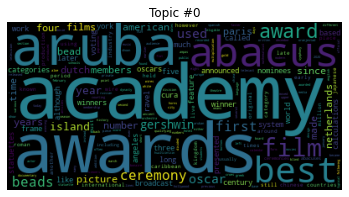

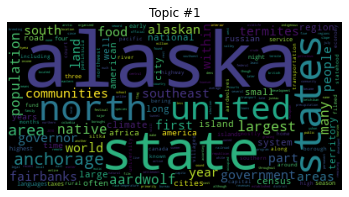

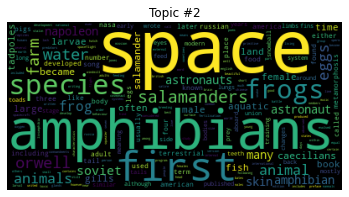

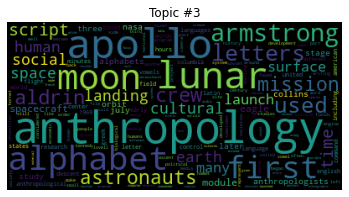

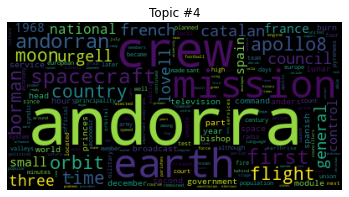

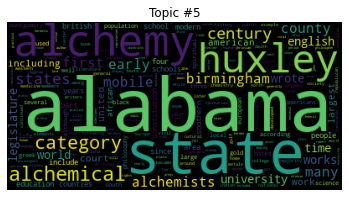

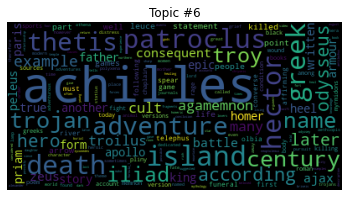

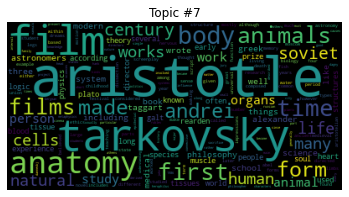

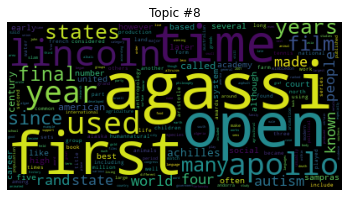

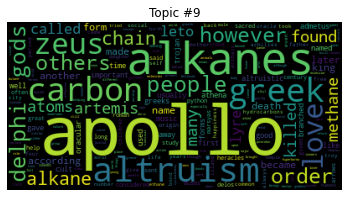

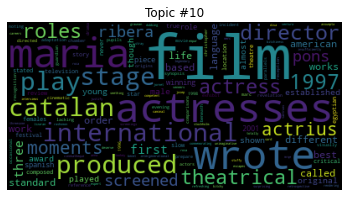

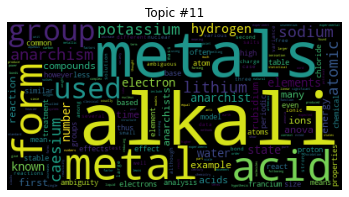

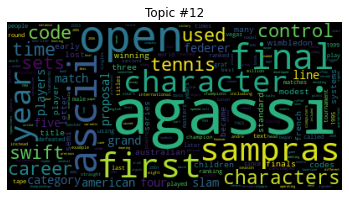

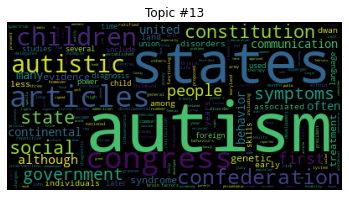

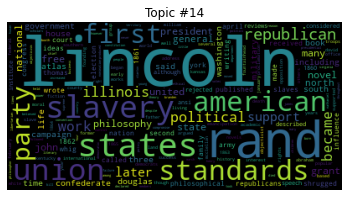

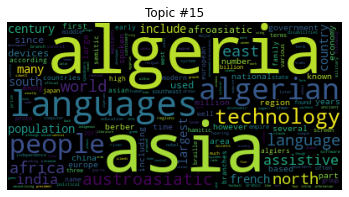

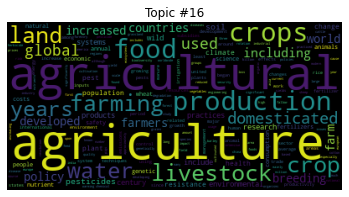

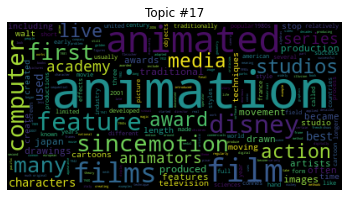

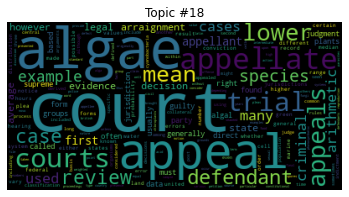

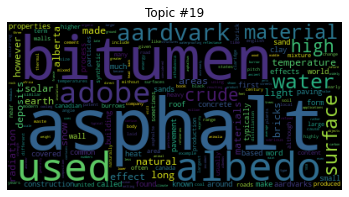

In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

#### Erweiterte Visualisierung der Topics
 * Nutzung der PyLDAvis Bibliothek zur interaktiven Visualisierung der generierten Topics auf dem trainierten LDA-Model
 * Data Analyst würde auf dieser Basis die Gütigkeit des Models testen und versuchen neue Muster und Trends zu interpretieren
 * Computing zur Generierung der interaktiven Bibliothek steigt bei Massendaten exponenziell

In [12]:
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

####  Eingehender Datensatz gegen Model testen

* Auswahl eines beliebigen Wikipedia Artikel. (In diesem Beispiel Lamborghini). 
* Artikel muss vorverarbeitet werden. Läuft also durch Spark Pipeline. Hierzu greifen wir auf die Clean Funktion zu, die wir ganz oben definiert haben
* Ergebnis ist ein Feature Vektor, den wir durch das LDA-Model laufen lassen
* Output-Ergebnis zeigt Topics mit der größten Übereinstimmung nach Wahrscheinlichkeit

In [13]:
article_title = 'Lamborghini'
cleaned_article_content = clean([article_title, wikipedia.page(article_title).content])[1]
print(list(lda_model[[dictionary.doc2bow(cleaned_article_content)]]))

[[(0, 0.11736508), (1, 0.10938548), (2, 0.045744732), (3, 0.06630932), (4, 0.09232412), (5, 0.027704919), (9, 0.025180478), (11, 0.037941888), (12, 0.2497239), (14, 0.08936319), (15, 0.12848301)]]
